# <center>Project-Based Assignment CLO-2</center>

<b>Topic</b>
Implementation of Supervised Learning on Regression Task

<b>Group Member</b>
1. Ikhsan Assidiqie - 1301213047
2. Zharfan Dawud Harwiraputera - 1301213359
3. Helmi Wira Tahta Haikal - 1301213436

Dataset: Power consumption of Tetouan city - https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city

Model: SVM/SVR

#### Background
Reliable predictions of power consumption are critical in a variety of industries, ranging from utility corporations and grid operators to individual customers and legislators. In this notebook, we will look at how to build an SVM model to predict power consumption from a given dataset. The primary goal of this project is to create a prediction model capable of estimating energy usage in a specified area.

In [ ]:
# Importing required libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from IPython.display import HTML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [ ]:
# Since we are using Google Colab, we make use of its drive to store the dataset so that it can be accessed from anywhere.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assigning the dataset onto df variable
df = pd.read_csv('/content/drive/My Drive/ML/Tetuan City power consumption.csv')

In [ ]:
# To explore the dataset we use the pandas-profiling package
# We already made the html file via VSCode, so we just uploaded that one into here
html_file_path = "/content/drive/My Drive/ML/Tetuan_City_power_consumption_report_ydata.html"

with open(html_file_path, 'r') as f:
    html_content = f.read()
HTML(html_content)


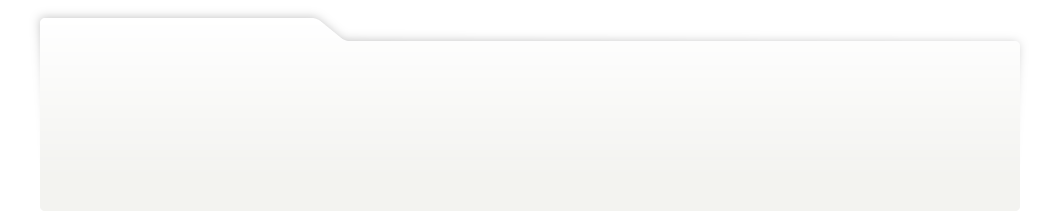
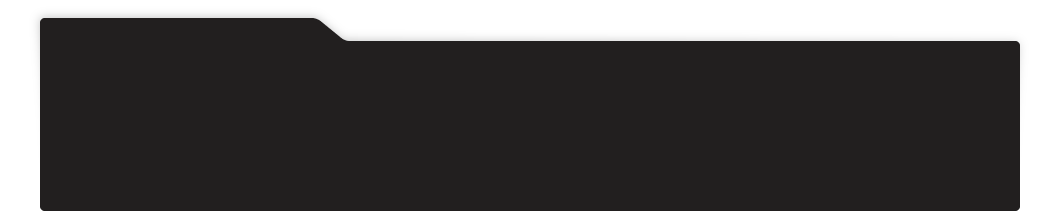
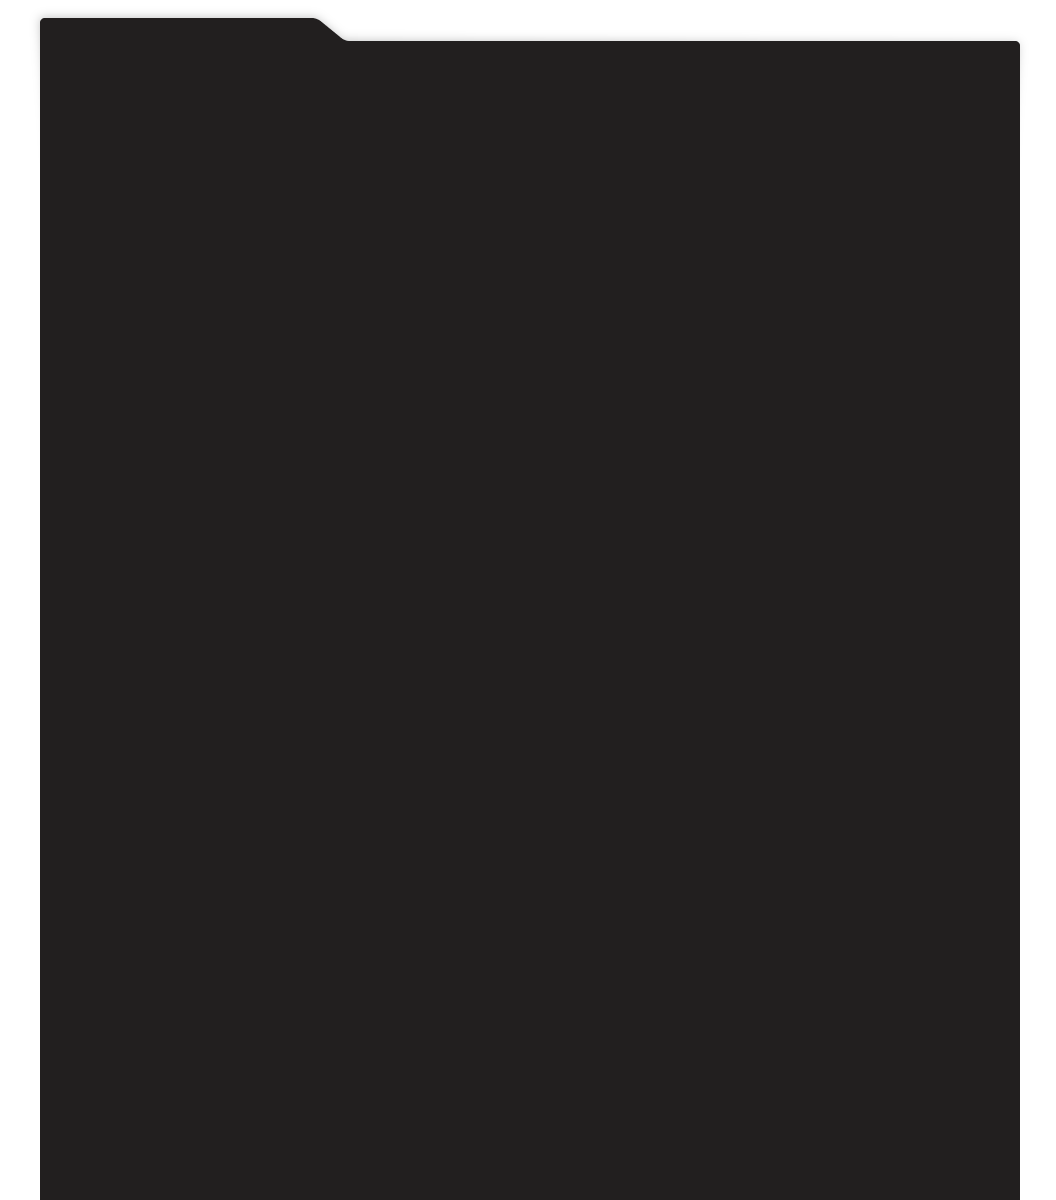
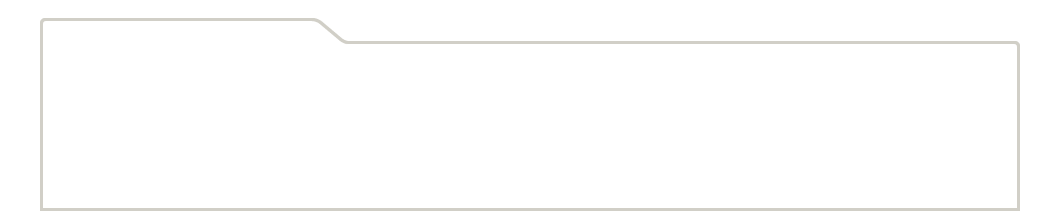
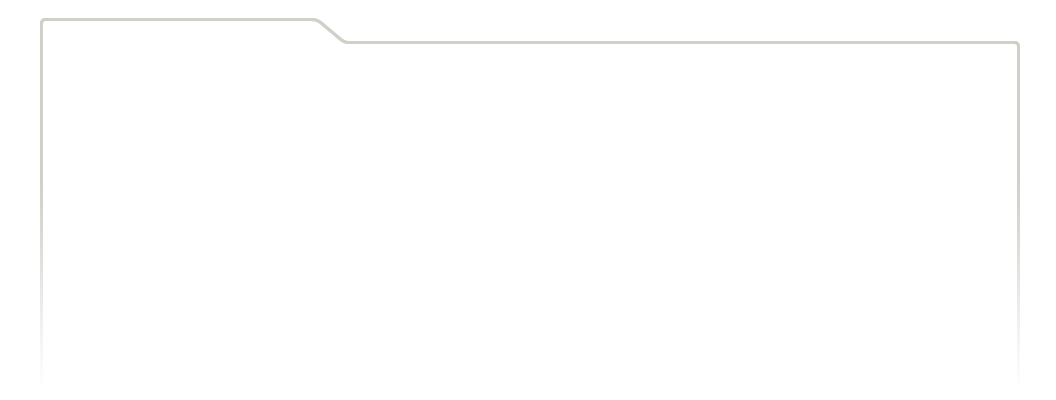
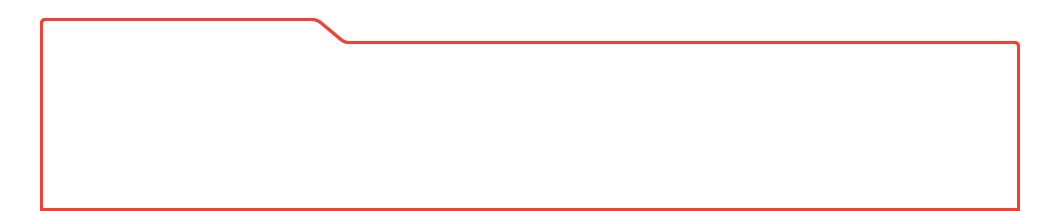
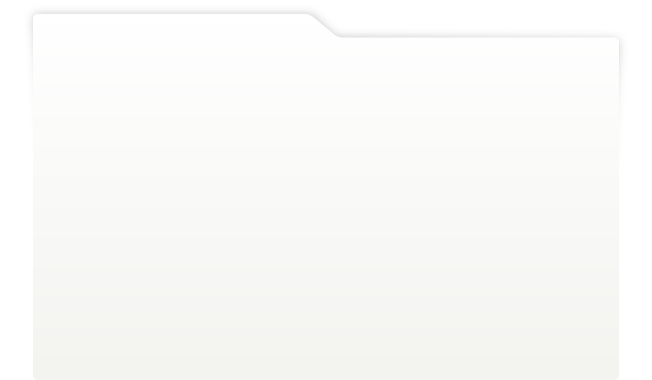
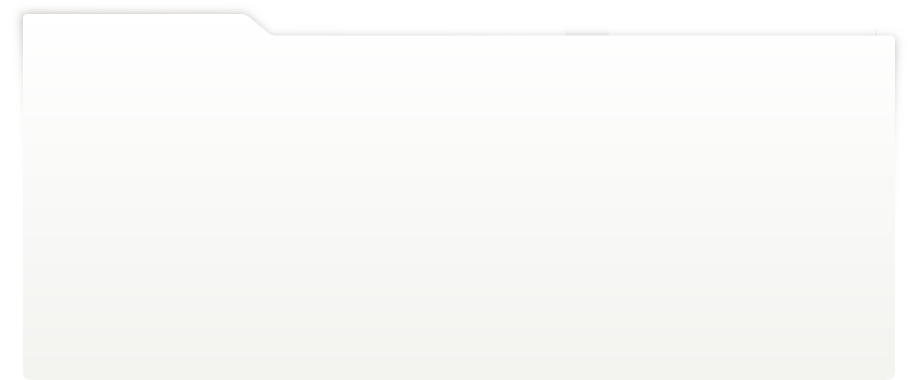
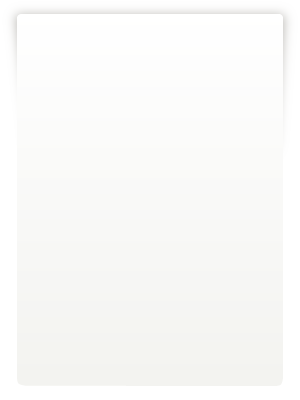
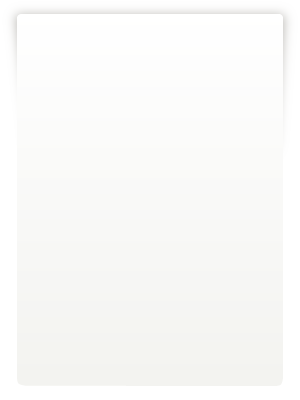
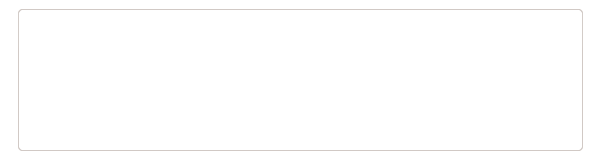
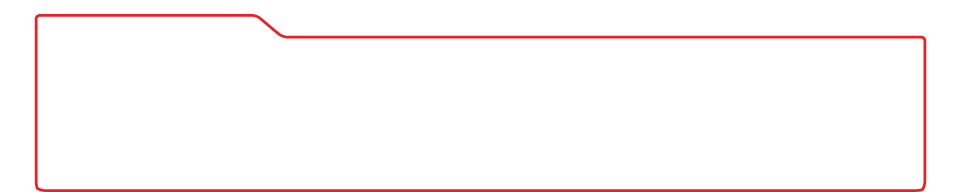
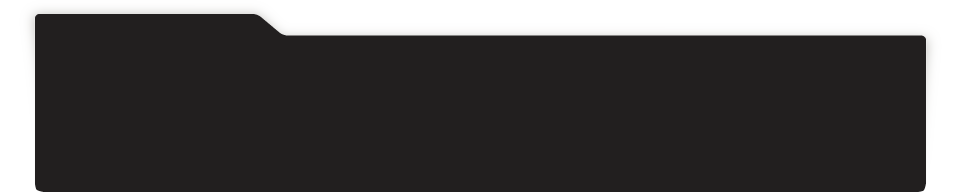
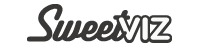
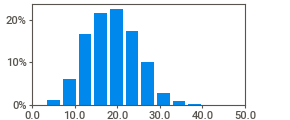
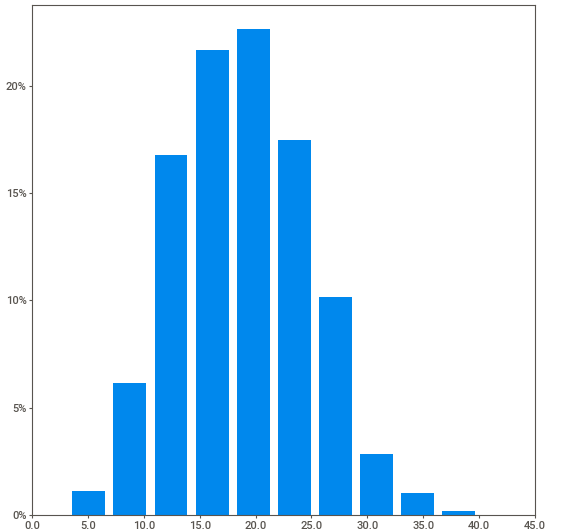
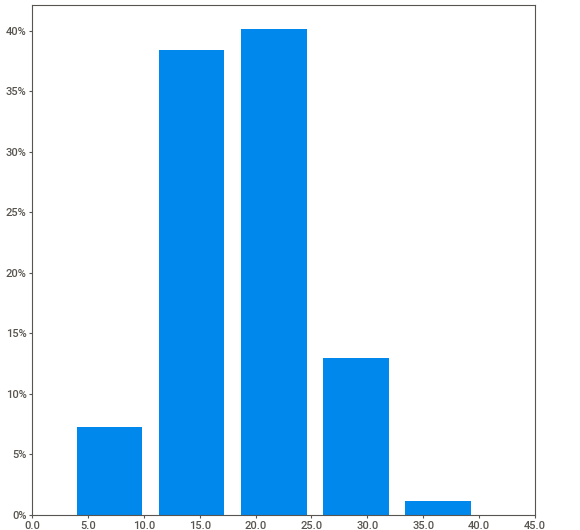
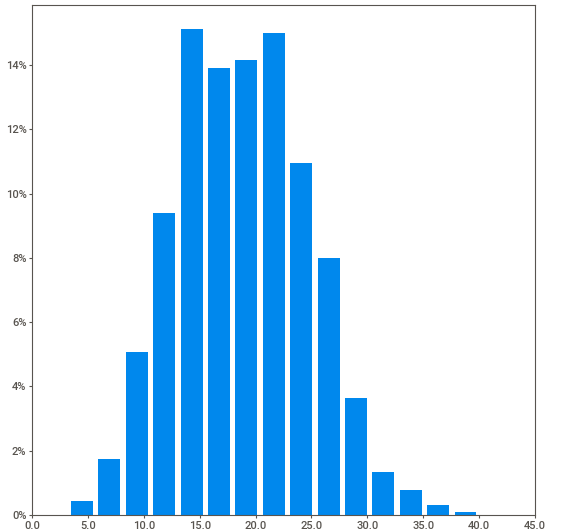
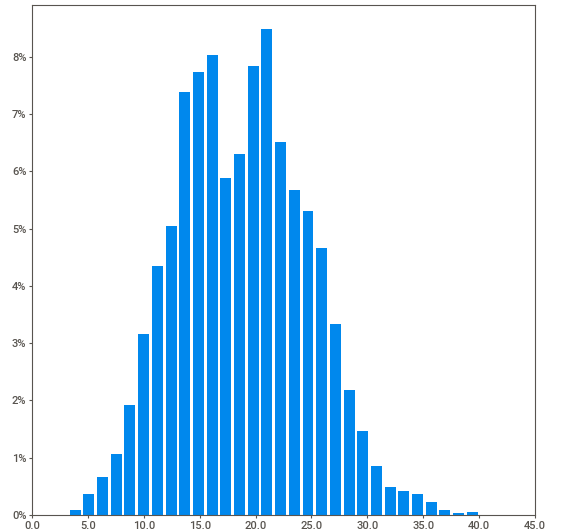
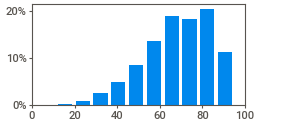
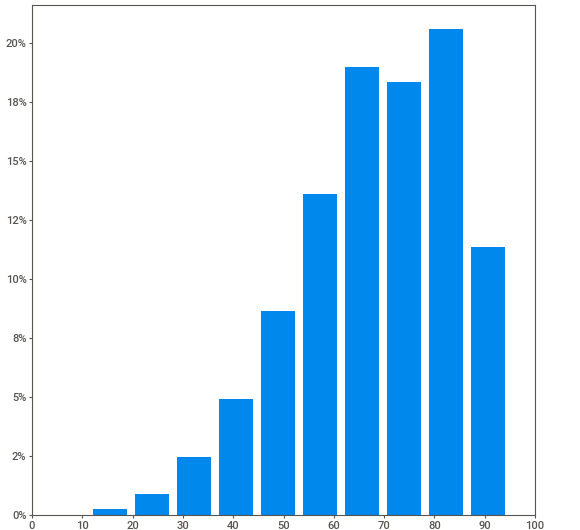
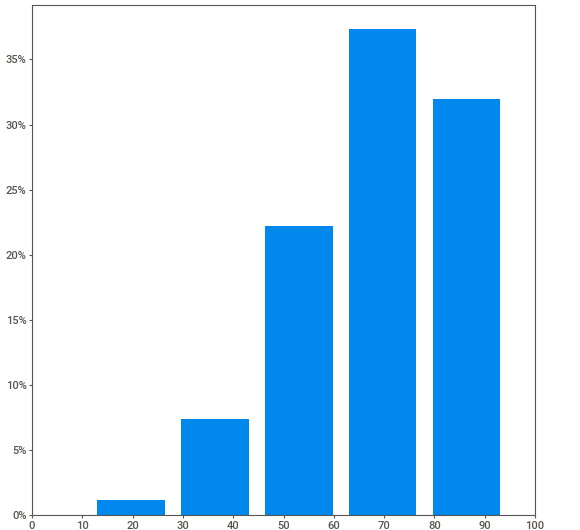
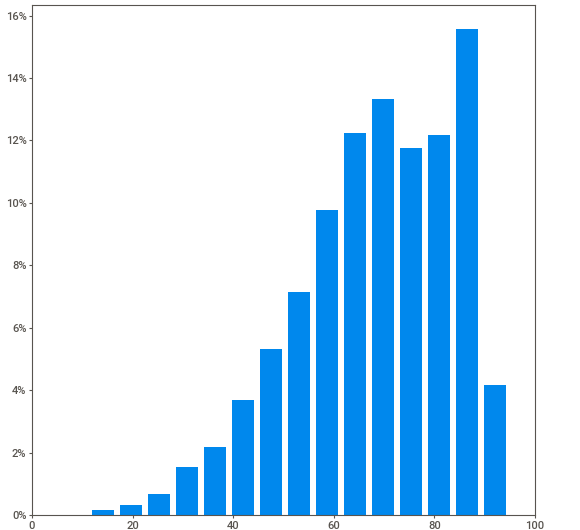
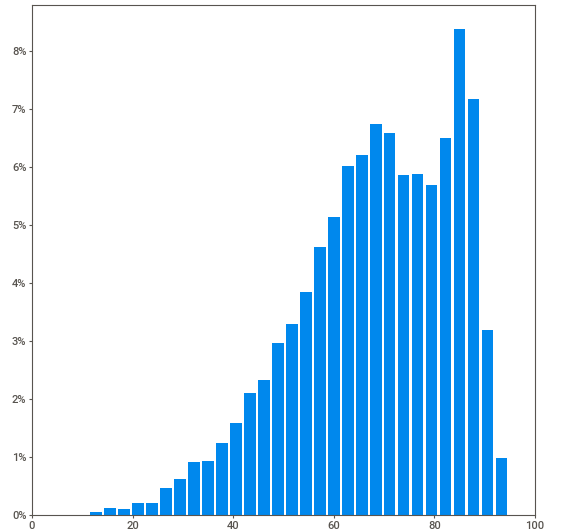
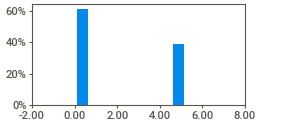
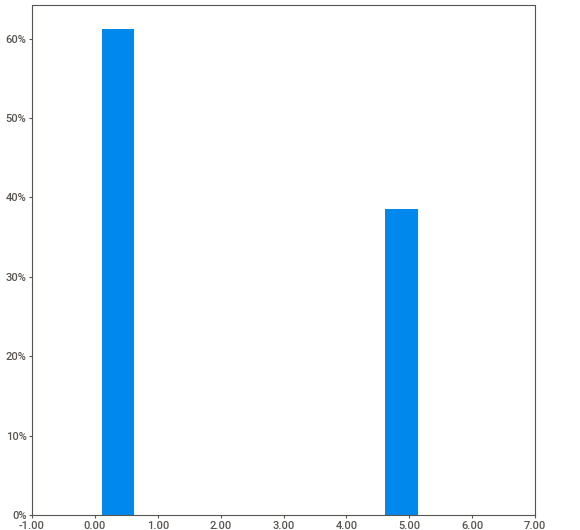
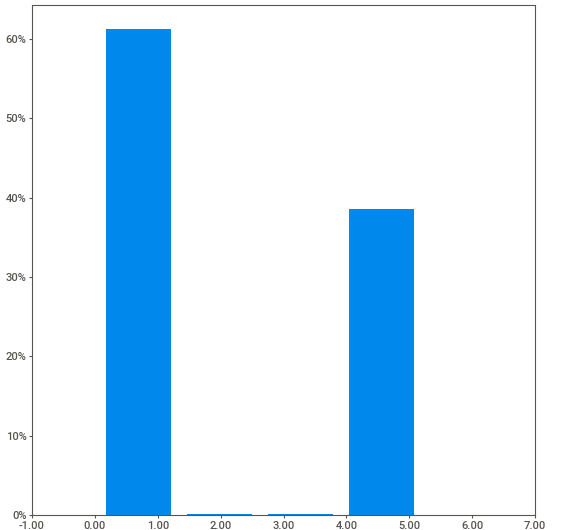
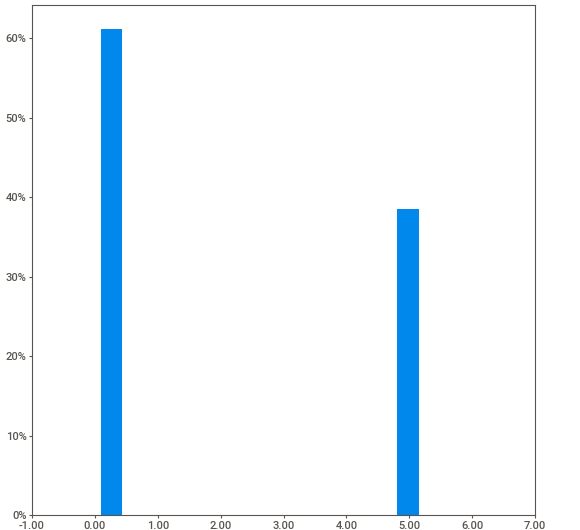
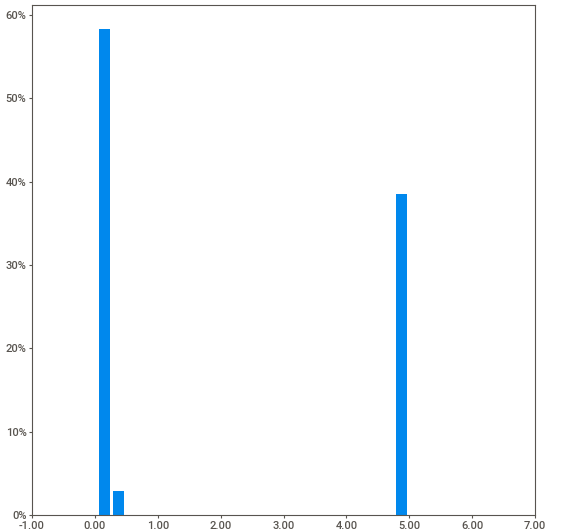
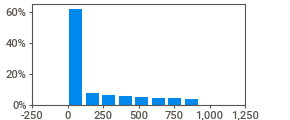
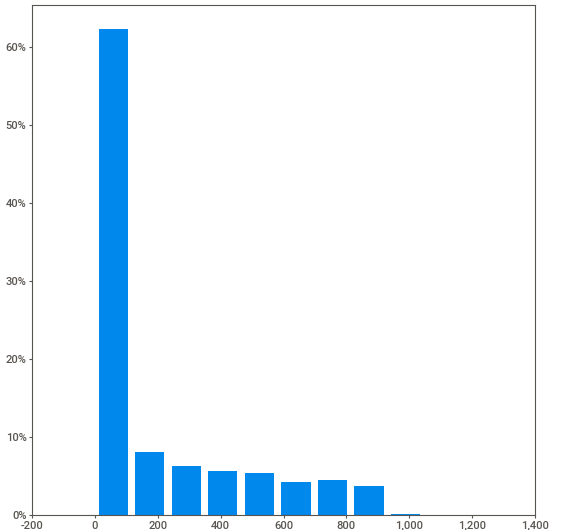
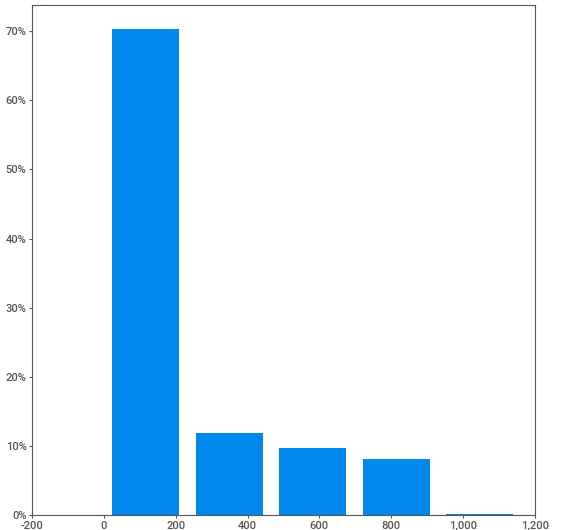
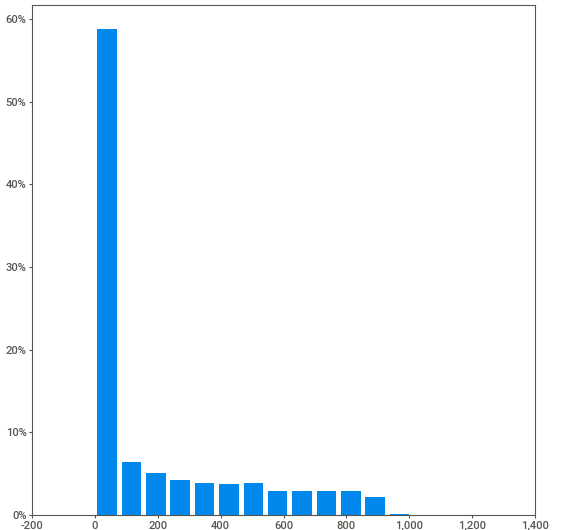
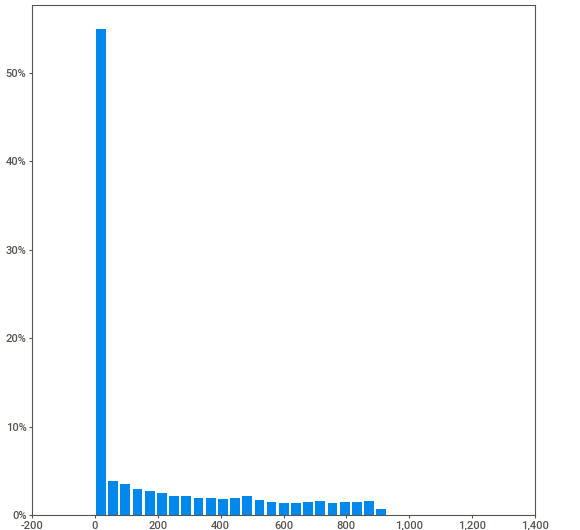
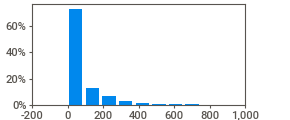
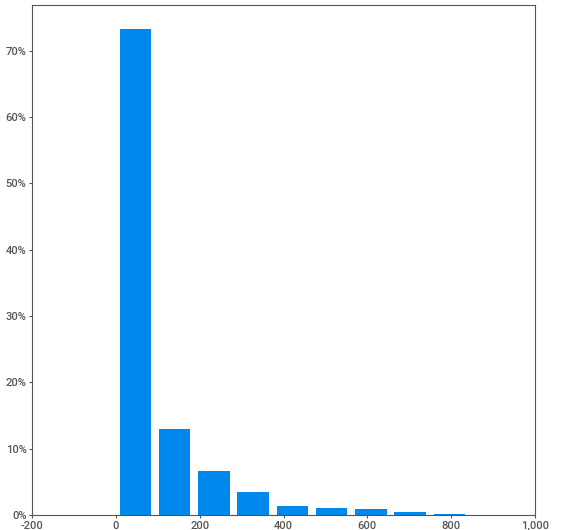
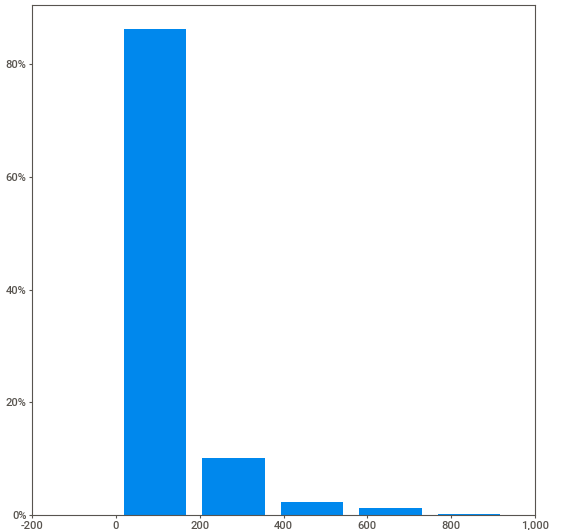
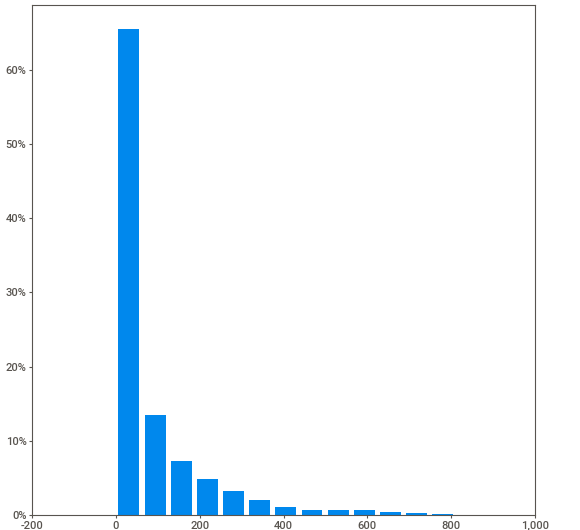
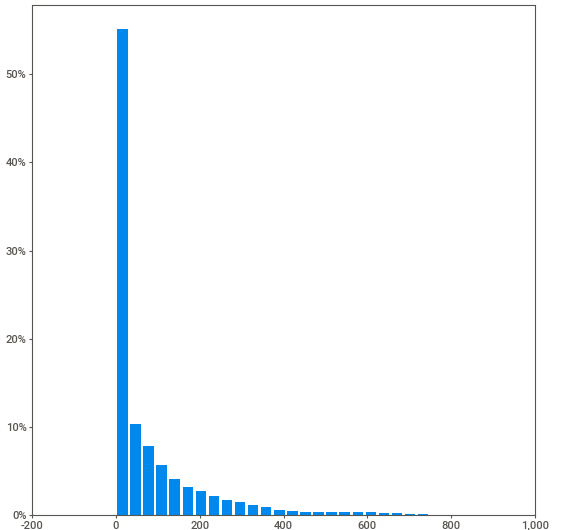
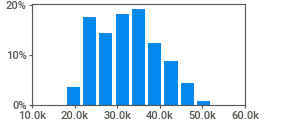
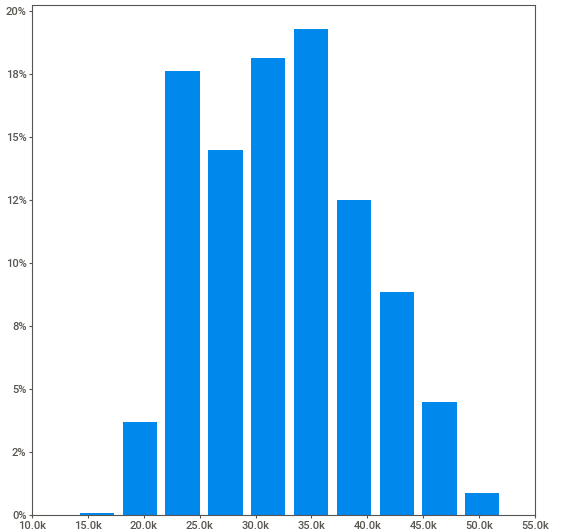
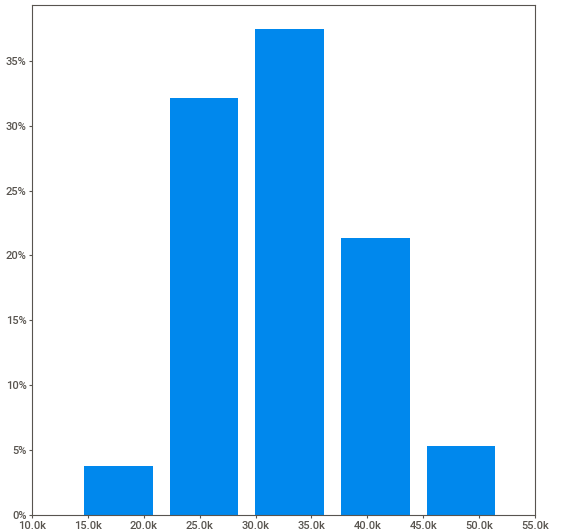
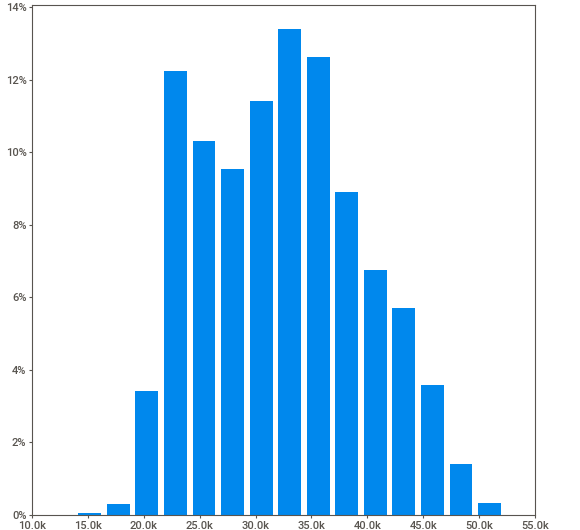
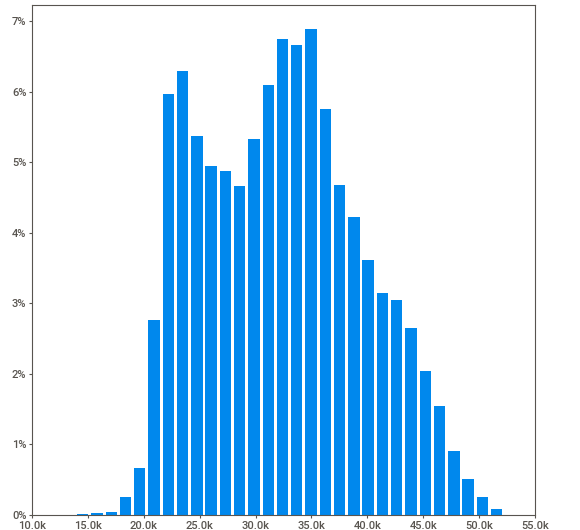
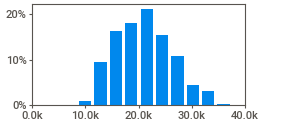
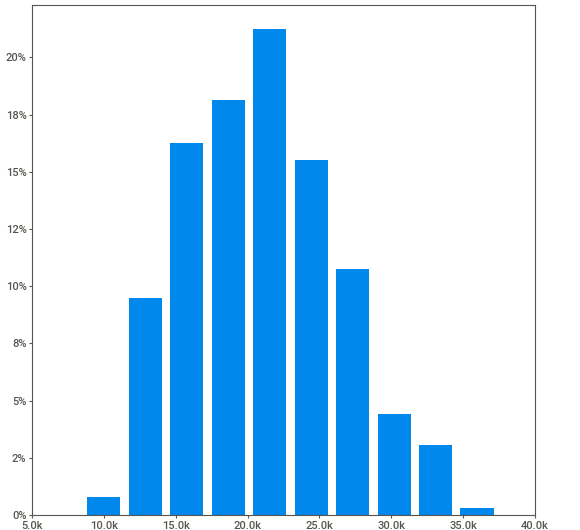
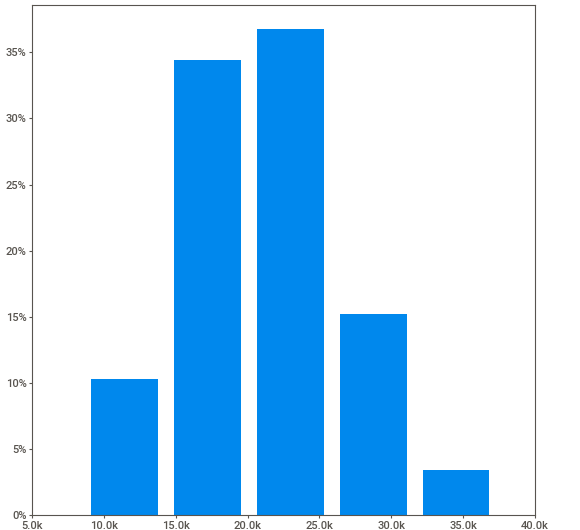
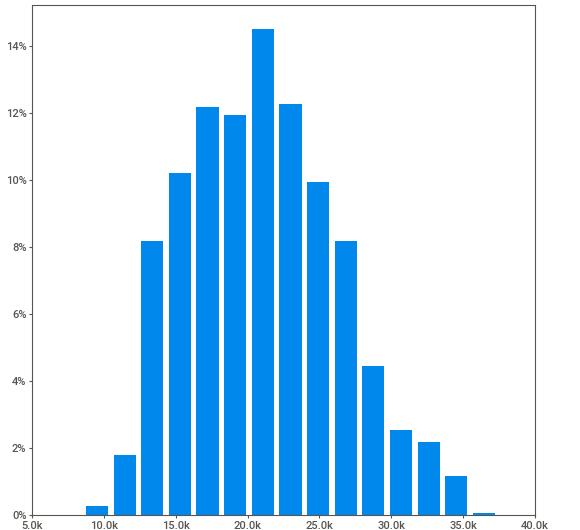
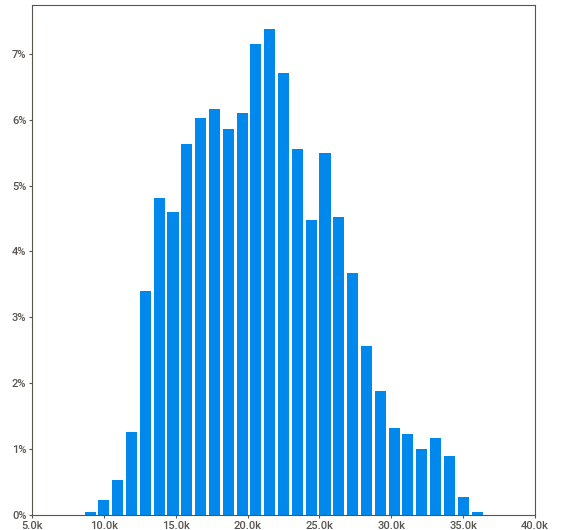
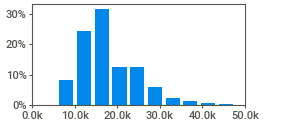
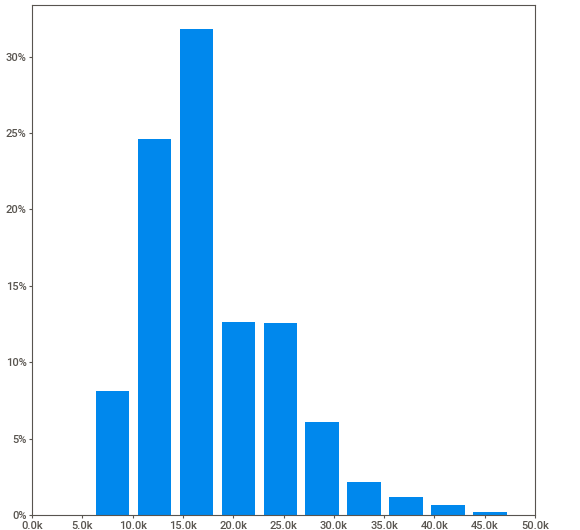
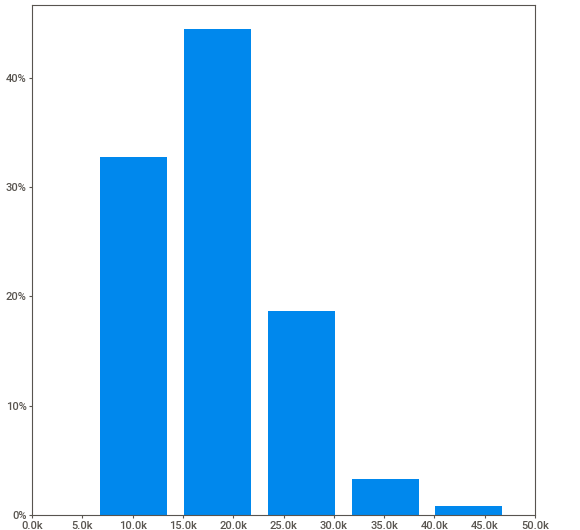
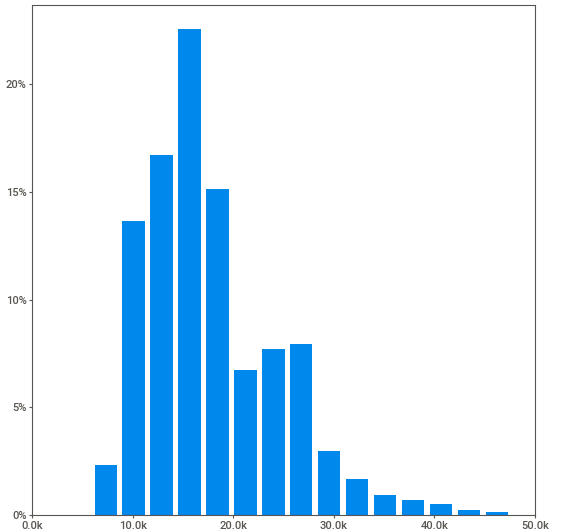
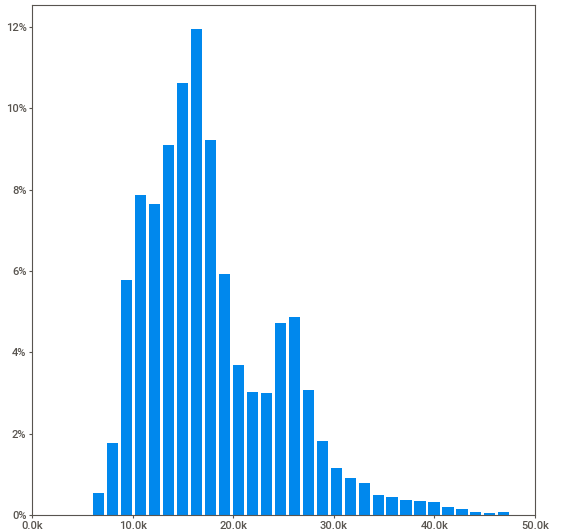
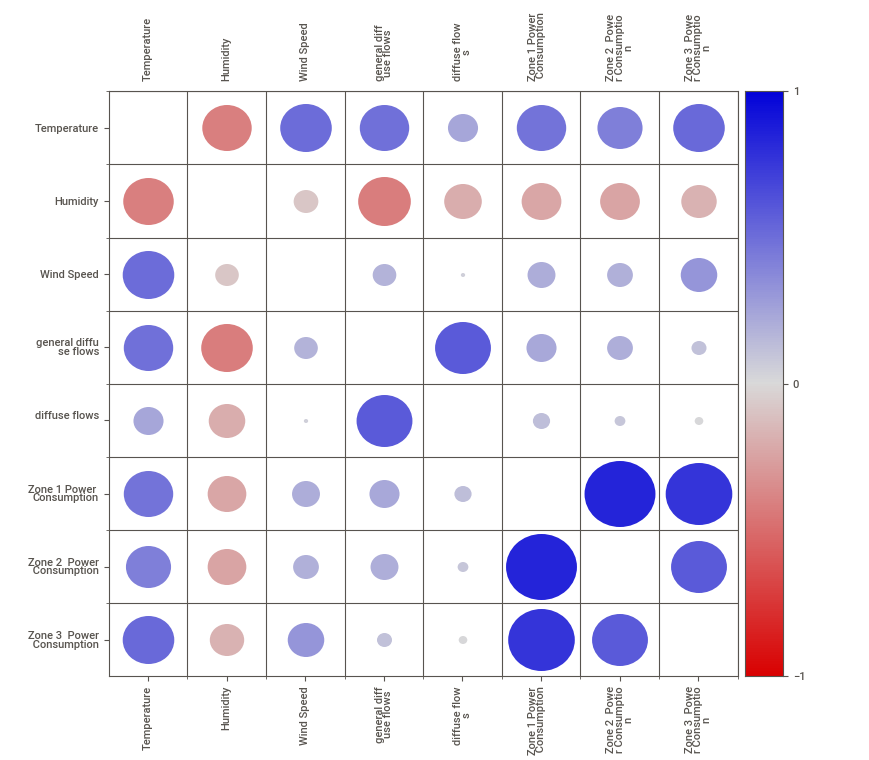
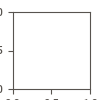

In [ ]:
# The same as above, using different package
html_file_path = "/content/drive/My Drive/ML/Tetuan_City_power_consumption_report_SWEETVIZ.html"

with open(html_file_path, 'r') as f:
    html_content = f.read()
HTML(html_content)

In [ ]:
# Extracting the hour from DateTime feature for future use
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Hour'] = df['DateTime'].dt.hour.astype(int)

# Since the time interval are of 10 minutes, we decided to also include the minutes into the dataset
# This will result in a HH.MM time format where its type is of real so that the model can actually read it
df['Minute'] = df['DateTime'].dt.minute
df['DecimalTime'] = df['Hour'] + df['Minute'] / 100

In [ ]:
# Feature scaling using normalization
features_to_normalize = ["Temperature", "Wind Speed", "diffuse flows","Humidity", "general diffuse flows"]
selected_features = df[features_to_normalize]
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(selected_features), columns=features_to_normalize)
df[features_to_normalize] = normalized_features

In [ ]:
df

DateTime  Temperature  Humidity  Wind Speed  \
0     2017-01-01 00:00:00     0.090091  0.748382    0.005130   
1     2017-01-01 00:10:00     0.086146  0.756770    0.005130   
2     2017-01-01 00:20:00     0.083399  0.756770    0.004663   
3     2017-01-01 00:30:00     0.078176  0.762761    0.005130   
4     2017-01-01 00:40:00     0.072736  0.771148    0.004819   
...                   ...          ...       ...         ...   
52411 2017-12-30 23:10:00     0.102358  0.731608    0.004663   
52412 2017-12-30 23:20:00     0.100645  0.734004    0.004974   
52413 2017-12-30 23:30:00     0.099366  0.736401    0.005596   
52414 2017-12-30 23:40:00     0.095504  0.738797    0.004663   
52415 2017-12-30 23:50:00     0.090662  0.751977    0.004819   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                   0.000040       0.000115               34055.69620   
1                   0.000057       0.000079               29814.68354   
2                   0.000050       0.000095               29128.10127   
3                   0.000075       0.000091               28228.86076   
4                   0.000038       0.000079               27335.69620   
...                      ...            ...                       ...   
52411               0.000031       0.000091               31160.45627   
52412               0.000040       0.000088               30430.41825   
52413               0.000069       0.000067               29590.87452   
52414               0.000053       0.000083               28958.17490   
52415               0.000050       0.000107               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  Hour  Minute  \
0                    16128.87538                20240.96386     0       0   
1                    19375.07599                20131.08434     0      10   
2                    19006.68693                19668.43373     0      20   
3                    18361.09422                18899.27711     0      30   
4                    17872.34043                18442.40964     0      40   
...                          ...                        ...   ...     ...   
52411                26857.31820                14780.31212    23      10   
52412                26124.57809                14428.81152    23      20   
52413                25277.69254                13806.48259    23      30   
52414                24692.23688                13512.60504    23      40   
52415                24055.23167                13345.49820    23      50   

       DecimalTime  
0              0.0  
1              0.1  
2              0.2  
3              0.3  
4              0.4  
...            ...  
52411         23.1  
52412         23.2  
52413         23.3  
52414         23.4  
52415         23.5  

[52416 rows x 12 columns]

#### Method Summary
We've chosen to use SVM for our model due to its user-friendliness and its ability to work well with non-linear relationships in the data. To optimize our predictions, we initially narrow down our feature selection, which simplifies the model fitting and prediction process. We then experiment with three different sets of hyperparameters, randomly selected, and analyze their results to determine which set yields the best outcome.

In [ ]:
# We first seperate the features and target to X and y respectively
X = df.drop(["Humidity","DateTime","diffuse flows","Zone 1 Power Consumption", "Zone 2  Power Consumption", "Zone 3  Power Consumption","Minute", "Hour"], axis=1)
y = df["Zone 1 Power Consumption"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% test

In [ ]:
X

Temperature  Wind Speed  general diffuse flows  DecimalTime
0         0.090091    0.005130               0.000040          0.0
1         0.086146    0.005130               0.000057          0.1
2         0.083399    0.004663               0.000050          0.2
3         0.078176    0.005130               0.000075          0.3
4         0.072736    0.004819               0.000038          0.4
...            ...         ...                    ...          ...
52411     0.102358    0.004663               0.000031         23.1
52412     0.100645    0.004974               0.000040         23.2
52413     0.099366    0.005596               0.000069         23.3
52414     0.095504    0.004663               0.000053         23.4
52415     0.090662    0.004819               0.000050         23.5

[52416 rows x 4 columns]

In [ ]:
y

0        34055.69620
1        29814.68354
2        29128.10127
3        28228.86076
4        27335.69620
            ...     
52411    31160.45627
52412    30430.41825
52413    29590.87452
52414    28958.17490
52415    28349.80989
Name: Zone 1 Power Consumption, Length: 52416, dtype: float64

#### Result and Analysis

The main show

##### Scheme 1

In [ ]:
model = SVR(kernel='rbf',gamma='auto', C=100, epsilon = 0.00001) # Hyper parameter, randomly selected
model.fit(X_train, y_train) # Training the model

# Validate the model
y_pred_scheme1 = model.predict(X_test)

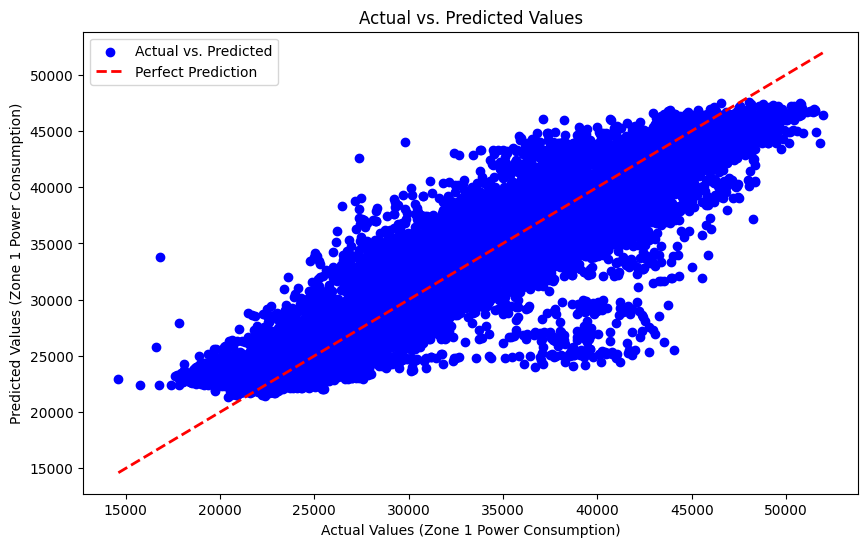

In [ ]:
# To visualize result
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_scheme1, c='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Zone 1 Power Consumption)')
plt.ylabel('Predicted Values (Zone 1 Power Consumption)')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
# We then evaluate using all MAE, MSE, RMSE, and R2
mae = mean_absolute_error(y_test, y_pred_scheme1)
mse = mean_squared_error(y_test, y_pred_scheme1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_scheme1)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 2193.9706
MSE: 8874348.5829
RMSE: 2978.9845
R²: 0.8263


##### Scheme 2

In [ ]:
model = SVR(kernel='rbf',gamma='auto', C=10000, epsilon = 0.0000001) # Hyper parameter, randomly selected
model.fit(X_train, y_train) # Training the model

# Validate the model
y_pred_scheme2 = model.predict(X_test)

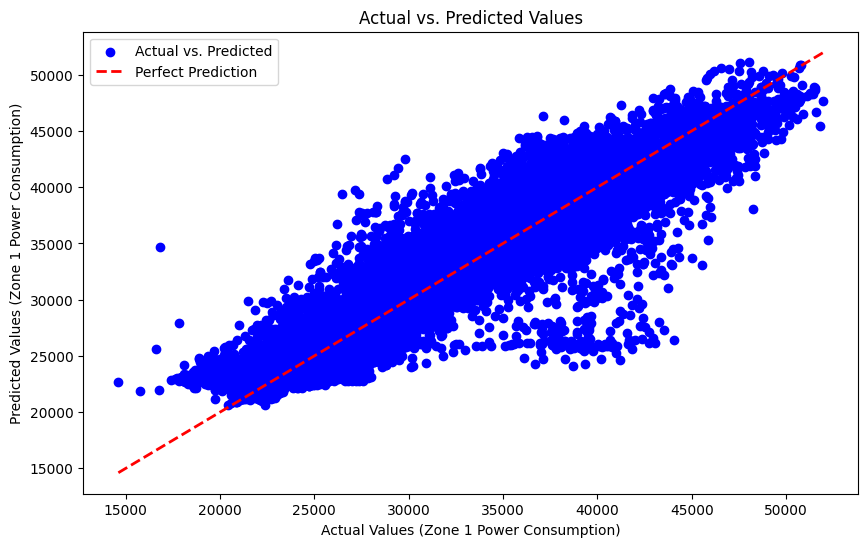

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_scheme2, c='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Zone 1 Power Consumption)')
plt.ylabel('Predicted Values (Zone 1 Power Consumption)')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred_scheme2)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_scheme2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred_scheme2)

# Print the evaluation metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 2001.5740
MSE: 7631018.4394
RMSE: 2762.4298
R²: 0.8506


##### Scheme 3

In [ ]:
model = SVR(kernel='rbf',gamma='auto', C=1000, epsilon = 0.000001) # Hyper parameter, randomly selected
model.fit(X_train, y_train)

y_pred_scheme3 = model.predict(X_test)

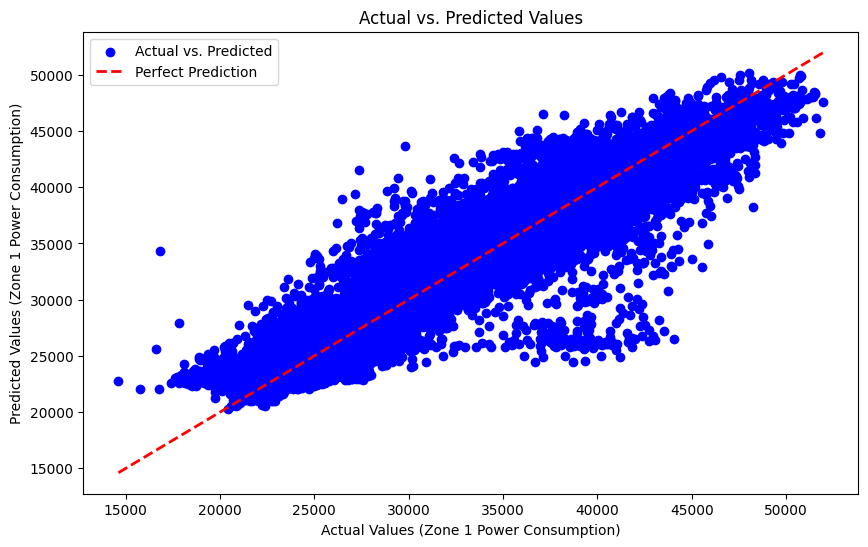

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_scheme3, c='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Zone 1 Power Consumption)')
plt.ylabel('Predicted Values (Zone 1 Power Consumption)')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred_scheme3)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_scheme3)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred_scheme3)

# Print the evaluation metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 2051.1095
MSE: 7887200.3921
RMSE: 2808.4160
R²: 0.8456


In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10],
#     'epsilon': [0.1, 0.2, 0.5],
#     'kernel': ['linear', 'poly', 'rbf']
# }

# grid_search = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)

#### Conclusion
After exploring three different combinations of hyperparameters for our (SVR) model to predict energy consumption, our analysis reveals that the second set of hyperparameters stands out as the optimal choice. It achieved the lowest MAE and MSE, indicating superior accuracy in predictions, as well as the lowest RMSE, reflecting more precise results. Furthermore, it exhibited the highest R² value, signifying that our model explained a greater proportion of the data's variance. These findings underscore the effectiveness of the second hyperparameter combination for energy consumption prediction, highlighting the potential of SVR as a valuable tool in energy management and resource planning. Further research could explore additional hyperparameter combinations and advanced techniques to refine model performance and its broader applications in energy efficiency and sustainability.